In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime


from sklearn.model_selection import  cross_validate, learning_curve, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.feature_selection import RFE
from dateutil.relativedelta import *


## Notebook Guide 
1. Prepocessing - quarterly lags
2. Naive model and linear regression model as baseline performance
3. Linear reg with PCA
4. Decision trees and optimisation 
5. RF and optimisation
6. Different preprocessing - smoothed (quarterly) lags, then applied to lin reg and RF

## Pre-processing
Removes NaNs, splits data using TimeSeriesSplit, creates 5 monthly lags, ensures feature and target indices match

In [50]:
df = pd.read_csv('index.csv')
df.insert(0, "Date", pd.to_datetime(df[["Year", "Month", "Day"]]))      # create datetime column
df.set_index(["Date"], inplace=True)                                    # set index to date, easy to handle 
df.drop(columns=["Year", "Month", "Day"], inplace=True)                 # deop redundant columns
df.drop(columns=["Federal Funds Target Rate", "Federal Funds Upper Target", "Federal Funds Lower Target"], inplace=True)        # these columns will not be used


targ_df = pd.DataFrame(df["Real GDP (Percent Change)"])     # create target and drop the NaNs to get to quarterly values


# determine date when inflation rate begins to ve recorded 
for i,j in enumerate(df["Inflation Rate"]):
    if not np.isnan(j):
        print(f"Inflation rates begin: {df.index[i]}")
        break        
 
df.drop(df.loc["1954-07-01":"1958-01-01"].index, inplace=True)      # drop the rows with no inflation rate
df.drop(df.loc["2016-11-01":].index, inplace=True) # drop as there is no target for these dates
targ_df.drop(targ_df.loc["1954-07-01":"1958-01-01"].index, inplace=True)      # drop the rows with no inflation rate
targ_df.drop(targ_df.loc["2016-11-01":].index, inplace=True) # drop as there is no target for these dates



# remove mid-month entries as these were wgen target rates were chanmged, theses only contain NaNs for our feqture vaeriables 
idx_mm = [i for i,j in enumerate(df.index.day) if j != 1]
df.drop(df.iloc[idx_mm].index, inplace=True) 
# same for targ df
idx_mm = [i for i,j in enumerate(targ_df.index.day) if j != 1]
targ_df.drop(targ_df.iloc[idx_mm].index, inplace=True) 




tss = TimeSeriesSplit(n_splits = 2)         # use time series train test split so we do not train on future data, 2 splits to increse cv sample size
for train_index, test_index in tss.split(df, targ_df):
    X_train, X_test = df.iloc[train_index, :].copy(), df.iloc[test_index,:].copy()
    y_train, y_test = targ_df.iloc[train_index].copy(), targ_df.iloc[test_index].copy()
X_train.drop(columns="Real GDP (Percent Change)", inplace=True)
X_test.drop(columns="Real GDP (Percent Change)", inplace=True)



lags = [1,2,3,4,5]        # introduce lag features 
cols = ["Effective Federal Funds Rate", "Inflation Rate", "Unemployment Rate"]  
# loop and dynamically name lags for train
for col in cols:
    for L in lags:
        X_train[f"{col} lag{L}"] = X_train[col].shift(L)
# same for test
for col in cols:
    for L in lags:
        X_test[f"{col} lag{L}"] = X_test[col].shift(L)


X_train.drop(X_train.iloc[0:5].index, inplace=True)
X_test.drop(X_test.iloc[0:5].index, inplace=True)




# Now need to reduce to quartely evaluation: 
y_train = y_train.loc["1958-08-01":"1997-03-01"]        # limits of X_train
y_train = y_train.dropna()                              # get rid of monthly values
X_train = X_train.loc[y_train.index]                    # use index of targ to change X
print(f"Check train indices: {sum(y_train.index != X_train.index)}")                     # check


# same for test dataset
y_test = y_test.loc["1997-10-01":"2016-10-01"]
y_test = y_test.dropna()
X_test = X_test.loc[y_test.index]
print(f"check test indices: {sum(y_test.index != X_test.index)}")

# create quarterly lags for GDP
gdp_lags = [1,2,3]
for L in gdp_lags:
    X_train[f"Real GDP (Percent Change) lag{L}"] = y_train["Real GDP (Percent Change)"].shift(L)

for L in gdp_lags:
    X_test[f"Real GDP (Percent Change) lag{L}"] = y_test["Real GDP (Percent Change)"].shift(L)



X_train.drop(X_train.iloc[0:3].index, inplace=True)
X_test.drop(X_test.iloc[0:3].index, inplace=True)
y_train.drop(y_train.iloc[0:3].index, inplace=True)
y_test.drop(y_test.iloc[0:3].index, inplace=True)

print(f'NaNs in X_train: {X_train[["Unemployment Rate", "Effective Federal Funds Rate", "Inflation Rate"]].isna().sum()}')       # check if all are removed
print(f'NaNs in y_train: {y_train["Real GDP (Percent Change)"].isna().sum()}')        # check if all are removed
print(f'NaNs in X_test: {X_test[["Unemployment Rate", "Effective Federal Funds Rate", "Inflation Rate"]].isna().sum()}')        # check if all are removed
print(f'NaNs in y_test: {y_test["Real GDP (Percent Change)"].isna().sum()}')        # check if all are removed


X_train.head(6)


Inflation rates begin: 1958-01-01 00:00:00
Check train indices: 0
check test indices: 0
NaNs in X_train: Unemployment Rate               0
Effective Federal Funds Rate    0
Inflation Rate                  0
dtype: int64
NaNs in y_train: 0
NaNs in X_test: Unemployment Rate               0
Effective Federal Funds Rate    0
Inflation Rate                  0
dtype: int64
NaNs in y_test: 0


,Effective Federal Funds Rate,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate lag1,Effective Federal Funds Rate lag2,Effective Federal Funds Rate lag3,Effective Federal Funds Rate lag4,Effective Federal Funds Rate lag5,Inflation Rate lag1,Inflation Rate lag2,...,Inflation Rate lag4,Inflation Rate lag5,Unemployment Rate lag1,Unemployment Rate lag2,Unemployment Rate lag3,Unemployment Rate lag4,Unemployment Rate lag5,Real GDP (Percent Change) lag1,Real GDP (Percent Change) lag2,Real GDP (Percent Change) lag3
Date,,,,,,,,,,,,,,,,,,,,,
1959-07-01,3.47,5.1,2.0,3.39,2.90,2.96,2.80,2.43,2.0,2.0,...,1.7,1.7,5.0,5.1,5.2,5.6,5.9,10.1,7.7,9.7
1959-10-01,3.98,5.7,2.7,3.76,3.50,3.47,3.39,2.90,2.4,2.0,...,2.0,2.0,5.5,5.2,5.1,5.0,5.1,-0.8,10.1,7.7
1960-01-01,3.99,5.2,2.0,3.99,4.00,3.98,3.76,3.50,2.0,2.0,...,2.4,2.0,5.3,5.8,5.7,5.5,5.2,1.6,-0.8,10.1
1960-04-01,3.92,5.2,2.0,3.84,3.97,3.99,3.99,4.00,2.0,2.3,...,2.0,2.0,5.4,4.8,5.2,5.3,5.8,9.2,1.6,-0.8
1960-07-01,3.23,5.5,1.3,3.32,3.85,3.92,3.84,3.97,1.7,1.7,...,2.0,2.3,5.4,5.1,5.2,5.4,4.8,-1.5,9.2,1.6
1960-10-01,2.47,6.1,1.0,2.60,2.98,3.23,3.32,3.85,1.0,1.3,...,1.7,1.7,5.5,5.6,5.5,5.4,5.1,1.0,-1.5,9.2


### Correlations

In [51]:
abs(X_train.corrwith(y_train["Real GDP (Percent Change)"])).sort_values(ascending=False)


Effective Federal Funds Rate lag4    0.413944
Effective Federal Funds Rate lag5    0.402652
Effective Federal Funds Rate lag3    0.399229
Effective Federal Funds Rate lag2    0.362330
Effective Federal Funds Rate lag1    0.331153
Inflation Rate                       0.330946
Inflation Rate lag1                  0.328236
Inflation Rate lag2                  0.326547
Effective Federal Funds Rate         0.317204
Inflation Rate lag3                  0.307583
Inflation Rate lag4                  0.293013
Inflation Rate lag5                  0.266075
Real GDP (Percent Change) lag1       0.264990
Unemployment Rate lag5               0.187682
Real GDP (Percent Change) lag2       0.183525
Unemployment Rate lag4               0.166176
Unemployment Rate lag3               0.141952
Unemployment Rate lag2               0.111981
Unemployment Rate lag1               0.069286
Real GDP (Percent Change) lag3       0.053542
Unemployment Rate                    0.001051
dtype: float64

### Naive Model - baseline

In [52]:
def naive_model(y):
    y_pred = np.zeros(len(y.index)+1)

    for i in range(len(y.index)):
        y_pred[i+1] = y["Real GDP (Percent Change)"].iloc[i]

    idx = list(y.index)
    idx.append(idx[-1] + relativedelta(months=+3))
    y_pred_df = pd.DataFrame(y_pred, idx)
    r2 = r2_score(y, y_pred_df[:-1])
    return r2

print(f"Naive model TRAIN R^2 = {naive_model(y_train):.3f}")
print(f"Naive model TEST R^2 = {naive_model(y_test):.3f}")

Naive model TRAIN R^2 = -0.429
Naive model TEST R^2 = -0.294


### Linear Ridge Regression as a baseline. 
Untuned.

In [53]:
rand=48
reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=0.1, random_state=rand))])         # instantiate pipeline class, setting the scaler and model (ridge regression)

#  time-series aware cross validation  
cv_reg = cross_validate(
    reg_pipe, X_train, y_train, cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)


print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")


CV Mean R2 (train):  0.587 ± 0.012
CV Mean R2 (val):    -0.427  ± 0.484
CV Mean RMSE (val):  3.693
CV Mean MAE (val):   2.980


Try just with EFFR, informed by correlations

In [54]:
reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=0.1, random_state=rand))])         # instantiate pipeline class, setting the scaler and model (ridge regression)

#  time-series aware cross validation  
cv_reg = cross_validate(
    reg_pipe, X_train[[i for i in X_train.columns if "Effective" in i]], y_train, cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)

print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")


CV Mean R2 (train):  0.181 ± 0.040
CV Mean R2 (val):    -0.155  ± 0.104
CV Mean RMSE (val):  3.574
CV Mean MAE (val):   2.848


Less overfit, but doesn't perform well. Less features means less variance, so closer to a mean prediction.

### Use RFE - Linear reg

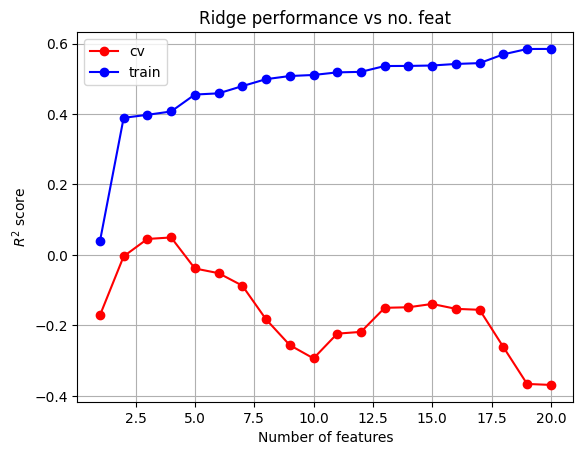

In [55]:
scaler = StandardScaler()
cv_score = []
train_score = []

for i in range(1,len(X_train.columns)):   
    rfe = RFE(Ridge(alpha=0.1, random_state=rand), n_features_to_select=i)
    rfe.fit(scaler.fit_transform(X_train), scaler.fit_transform(y_train))
    cols = X_train.columns[rfe.support_]
    X_rfe = X_train[cols]

    #  time-series aware cross validation  
    cv_reg = cross_validate(
        reg_pipe, X_rfe, y_train, cv=tss, n_jobs=-1,
        scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
        return_train_score=True)

    cv_score.append(cv_reg['test_r2'].mean())
    train_score.append(cv_reg['train_r2'].mean())
    # print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}               {i}")
    # print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}\n")

# plt.figure(figsize=(9,7))
plt.plot(range(1, len(X_train.columns)), cv_score, 'o-', color='r', label='cv') 
plt.plot(range(1, len(X_train.columns)), train_score, 'o-', color='b', label='train')
plt.xlabel("Number of features")
plt.ylabel("$R^2$ score")
plt.title("Ridge performance vs no. feat")
plt.legend()
plt.grid()
plt.show()

Optimum is 5

In [56]:
rfe = RFE(Ridge(alpha=0.1, random_state=rand), n_features_to_select=5)
rfe.fit(scaler.fit_transform(X_train), scaler.fit_transform(y_train))
cols = X_train.columns[rfe.support_]
X_rfe = X_train[cols]

cv_reg = cross_validate(
        reg_pipe, X_rfe, y_train, cv=tss, n_jobs=-1,
        scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
        return_train_score=True)


print(X_train.columns[rfe.support_])
print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}               {5}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}\n")


Index(['Effective Federal Funds Rate', 'Unemployment Rate',
       'Unemployment Rate lag1', 'Unemployment Rate lag2',
       'Unemployment Rate lag3'],
      dtype='object')
CV Mean R2 (train):  0.455 ± 0.024               5
CV Mean R2 (val):    -0.038  ± 0.329



### PCA
Creates independent, uncorrelated variables that expain a prescribed percentage of the variance. The low multicollinearity and reduced noise can reduce the variance in the model.

In [57]:
_ = StandardScaler().fit_transform(X_train)
pca = PCA(n_components=0.95, random_state=rand)     # PCs explain 95% of the variance 
X_pca = pca.fit_transform(_)
X_pca.shape
names = pca.get_feature_names_out()
X_pca_df = pd.DataFrame({names[0] : X_pca[:,0], 
                         names[1] : X_pca[:,1], 
                         names[2] : X_pca[:,2], 
                         names[3] : X_pca[:,3], 
                         names[4] : X_pca[:,4]})
X_pca_df.set_index(X_train.index, inplace=True)
X_pca_df.head(5)


,pca0,pca1,pca2,pca3,pca4
Date,,,,,
1959-07-01,-4.266252,0.457184,1.140030,1.490411,0.349469
1959-10-01,-3.583481,-0.121403,0.317490,-0.194183,1.556648
1960-01-01,-3.133817,0.088335,-0.237965,-0.875240,1.427111
1960-04-01,-3.278229,0.240577,-0.489622,0.017277,-1.916510
1960-07-01,-3.515672,-0.024830,-0.341755,-0.955839,0.299838


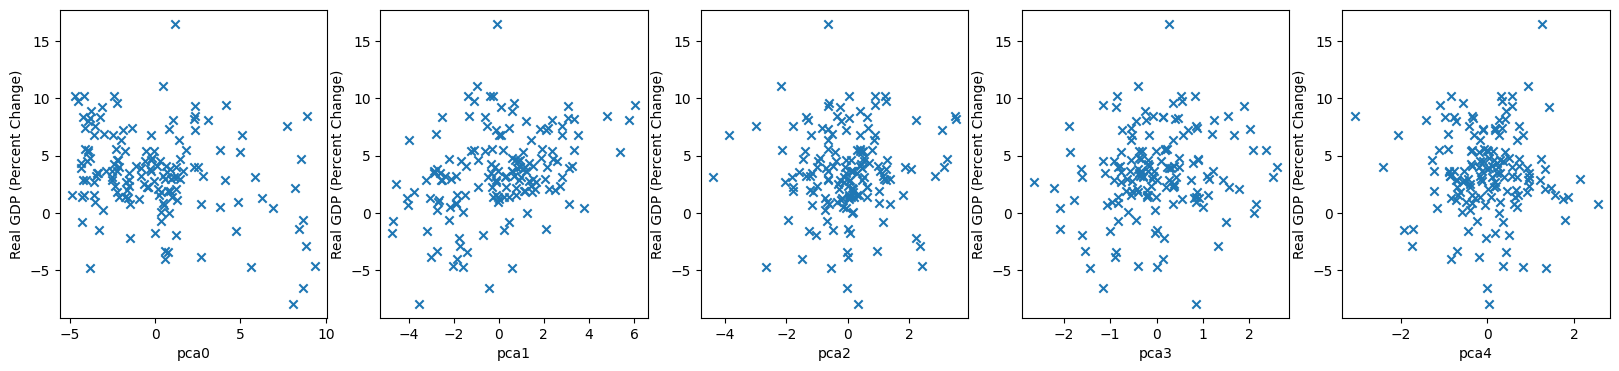

In [58]:
idx = X_pca_df.index
fig, ax = plt.subplots(1,5, figsize=(20,4))
for i,j in enumerate(X_pca_df.columns): 
    ax[i].scatter(X_pca_df[j], y_train["Real GDP (Percent Change)"], marker='x')
    ax[i].set_xlabel(f"{j}")
    ax[i].set_ylabel("Real GDP (Percent Change)")


In [59]:
print(f"Correlations with target: \n{X_pca_df.corrwith(y_train['Real GDP (Percent Change)'])}\n")
# for i in X_train.columns:
#     print(f"AVG correlation with {i}: \n{X_pca_df.corrwith(X_train[i]).sum()/5}")


Correlations with target: 
pca0   -0.286188
pca1    0.357798
pca2    0.018762
pca3    0.161534
pca4   -0.034263
dtype: float64



### Test on Ridge Regression:

In [60]:
pipe = Pipeline([("scaler", StandardScaler()), 
         ("PCA", PCA(n_components=0.95, random_state=rand)), 
         ("model", Ridge(alpha=0.1,random_state=rand))])

cv_reg = cross_validate(
    pipe, X_train, y_train, cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)


print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")


CV Mean R2 (train):  0.212 ± 0.066
CV Mean R2 (val):    -0.181  ± 0.176
CV Mean RMSE (val):  3.560
CV Mean MAE (val):   2.798


## Decision Trees

In [61]:
DT = DecisionTreeRegressor(random_state=rand, max_depth=20)
cv_reg = cross_validate(
    DT, X_train, y_train["Real GDP (Percent Change)"], cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)


print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")


CV Mean R2 (train):  1.000 ± 0.000
CV Mean R2 (val):    -3.418  ± 3.297
CV Mean RMSE (val):  5.254
CV Mean MAE (val):   4.111


In [62]:
param_grid = {'max_depth': [None,1,2,3,4, 5, 6,7,8,9,10,],         # limit tree depth 
}

DT = DecisionTreeRegressor(random_state=rand)

search = GridSearchCV(
    estimator=DT,
    param_grid=param_grid,               # number of random combinations to try
    cv=tss,                     # cross-validation folds
    scoring='r2',             # or 'neg_mean_squared_error'
    n_jobs=-1,
    verbose=1)

search.fit(X_train, y_train["Real GDP (Percent Change)"])


results = search.cv_results_
cv = pd.DataFrame(search.cv_results_)

cv_top = pd.DataFrame(cv.sort_values('mean_test_score', ascending=False).head(10))    
print(search.best_params_)
cv_top[["param_max_depth",'mean_test_score','std_test_score']]


Fitting 2 folds for each of 11 candidates, totalling 22 fits
{'max_depth': 1}


,param_max_depth,mean_test_score,std_test_score
1,1,-0.359983,0.353896
2,2,-0.854958,0.643855
3,3,-1.002983,0.982963
4,4,-2.405484,2.257917
8,8,-2.912130,2.862707
5,5,-3.126259,2.871797
0,None,-3.417877,3.297484
10,10,-3.425490,3.305096
9,9,-3.479437,3.359044
6,6,-3.591128,3.383150


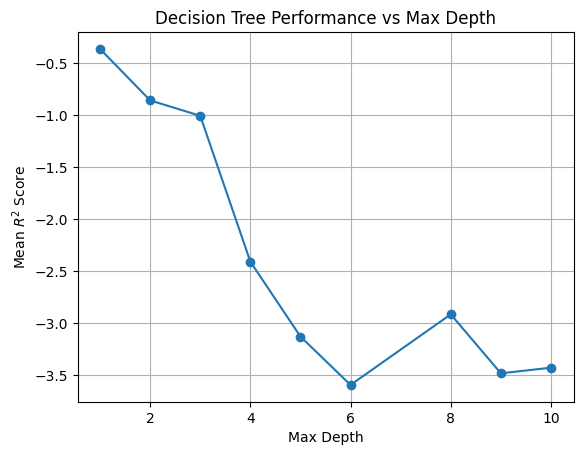

In [63]:
cv_top.sort_values("param_max_depth", ascending=True)[["param_max_depth", "mean_test_score"]]
plt.plot(cv_top.sort_values("param_max_depth", ascending=True)[["param_max_depth"]], cv_top.sort_values("param_max_depth", ascending=True)[["mean_test_score"]], "o-")
plt.grid()
plt.xlabel("Max Depth")
plt.ylabel("Mean $R^2$ Score")
plt.title("Decision Tree Performance vs Max Depth")
plt.show()

Introducing model complexity decreases performance

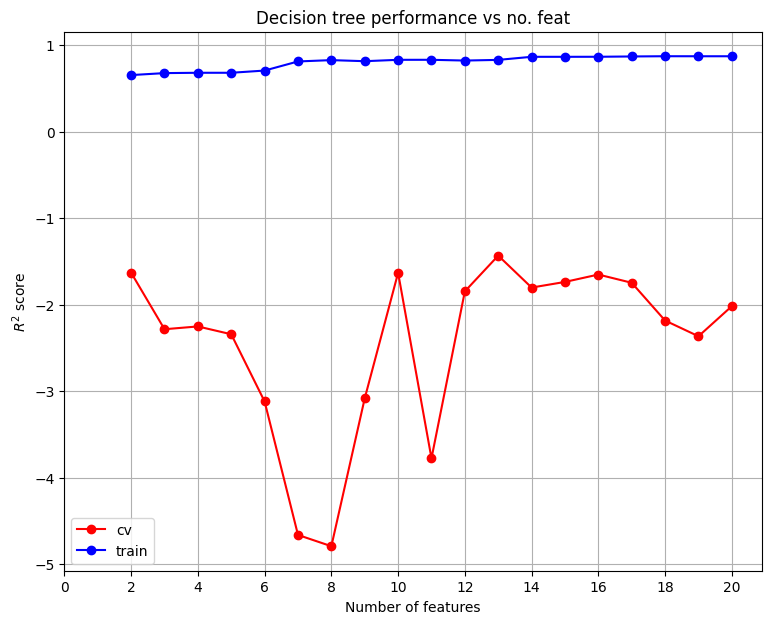

In [64]:
scaler = StandardScaler()
D_pipe = Pipeline([
    ("scaler", scaler),
    ("model", DecisionTreeRegressor(max_depth=5, random_state=rand))])    

cv_score = []
train_score = []

for i in range(2, len(X_train.columns)):
    rfe = RFE(DecisionTreeRegressor(max_depth=5, random_state=rand), n_features_to_select=i)
    rfe.fit(scaler.fit_transform(X_train), scaler.fit_transform(y_train))
    cols = X_train.columns[rfe.support_]
    X_rfe = X_train[cols]

    #  time-series aware cross validation  
    cv_reg = cross_validate(
        D_pipe, X_rfe, y_train, cv=tss, n_jobs=-1,
        scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
        return_train_score=True)

    cv_score.append(cv_reg['test_r2'].mean())
    train_score.append(cv_reg['train_r2'].mean())
    # print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}               {i}")
    # print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}\n")

plt.figure(figsize=(9,7))
plt.plot(range(2, len(X_train.columns)), cv_score, 'o-', color='r', label='cv') 
plt.plot(range(2, len(X_train.columns)), train_score, 'o-', color='b', label='train')
plt.title("Decision tree performance vs no. feat")
plt.xlabel("Number of features")
plt.ylabel("$R^2$ score")
plt.xticks(np.arange(0,len(X_train.columns), 2))
plt.legend()
plt.grid()
plt.show()

## Basic RF

In [65]:
rf = RandomForestRegressor(n_estimators=100, random_state=rand)
cv_reg = cross_validate(
    rf, X_train, y_train["Real GDP (Percent Change)"], cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)


print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")

CV Mean R2 (train):  0.869 ± 0.018
CV Mean R2 (val):    -0.773  ± 0.870
CV Mean RMSE (val):  3.879
CV Mean MAE (val):   3.188


RF fits the training data very well, does not generalise to cv.

## Optimise RF

In [66]:
param_grid = {
    'n_estimators': [40],       # no of trees
    'max_depth': [None,1,2,3,4, 5, 6,7,8,9,10,]        # limit tree depth     
}

rf = RandomForestRegressor(random_state=rand)

search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,               
    cv=tss,                    
    scoring='r2',           
    n_jobs=-1,
    verbose=1)

search.fit(X_train, y_train["Real GDP (Percent Change)"])

results = search.cv_results_
cv = pd.DataFrame(search.cv_results_)
cv["max_depth"] = cv["param_max_depth"]
cv["n_estimators"] = cv["param_n_estimators"]

cv_top = pd.DataFrame(cv.sort_values('mean_test_score', ascending=False).head(5))    # show the best 5
print(search.best_params_)
cv_top[['max_depth','mean_test_score','std_test_score']]

Fitting 2 folds for each of 11 candidates, totalling 22 fits
{'max_depth': 1, 'n_estimators': 40}


,max_depth,mean_test_score,std_test_score
1,1,-0.163249,0.216032
2,2,-0.288817,0.354514
3,3,-0.521867,0.598173
4,4,-0.550766,0.669282
5,5,-0.654674,0.737211


Optimal max depth of 1 - lowest compexity model. 

In [67]:
best_model = search.best_estimator_
cv_reg = cross_validate(best_model, 
    X_train, y_train["Real GDP (Percent Change)"], cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)


print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")


CV Mean R2 (train):  0.287 ± 0.025
CV Mean R2 (val):    -0.163  ± 0.216
CV Mean RMSE (val):  3.498
CV Mean MAE (val):   2.769


# Different pre-processing method - Smoothing data with quarterly averages
Data is noisy and models may be fitting this noise. Smoothing can reduce random noise from monthly features.

In [68]:
df = pd.read_csv('index.csv')
df.insert(0, "Date", pd.to_datetime(df[["Year", "Month", "Day"]]))      # create datetime column
df.set_index(["Date"], inplace=True)                                    # set index to date, easy to handle 
df.drop(columns=["Year", "Month", "Day"], inplace=True)                 # deop redundant columns
df.drop(columns=["Federal Funds Target Rate", "Federal Funds Upper Target", "Federal Funds Lower Target"], inplace=True)        # these columns will not be used


targ_df = pd.DataFrame(df["Real GDP (Percent Change)"])     # create target and drop the NaNs to get to quarterly values


# determine date when inflation rate begins to ve recorded 
for i,j in enumerate(df["Inflation Rate"]):
    if not np.isnan(j):
        print(f"Inflation rates begin: {df.index[i]}")
        break        
 
df.drop(df.loc["1954-07-01":"1958-01-01"].index, inplace=True)      # drop the rows with no inflation rate
df.drop(df.loc["2016-11-01":].index, inplace=True) # drop as there is no target for these dates
targ_df.drop(targ_df.loc["1954-07-01":"1958-01-01"].index, inplace=True)      # drop the rows with no inflation rate
targ_df.drop(targ_df.loc["2016-11-01":].index, inplace=True) # drop as there is no target for these dates



# remove mid-month entries as these were wgen target rates were chanmged, theses only contain NaNs for our feqture vaeriables 
idx_mm = [i for i,j in enumerate(df.index.day) if j != 1]
df.drop(df.iloc[idx_mm].index, inplace=True) 
# same for targ df
idx_mm = [i for i,j in enumerate(targ_df.index.day) if j != 1]
targ_df.drop(targ_df.iloc[idx_mm].index, inplace=True) 


tss = TimeSeriesSplit(n_splits = 2)         # use time series train test split so we do not train on future data, 2 splits to increse cv sample size
for train_index, test_index in tss.split(df, targ_df):
    X_train_sm, X_test_sm = df.iloc[train_index, :].copy(), df.iloc[test_index,:].copy()
    y_train_sm, y_test_sm = targ_df.iloc[train_index].copy(), targ_df.iloc[test_index].copy()
X_train_sm.drop(columns="Real GDP (Percent Change)", inplace=True)
X_test_sm.drop(columns="Real GDP (Percent Change)", inplace=True)



### --------------- Rolling avg features ------------------------
def rolling_avg(X, col, y): 
    mean = []
    for i in y.index:
        idx = X[col].index.get_loc(i)
        mean.append(np.mean([X[col].iloc[idx-1], X[col].iloc[idx-2], X[col].iloc[idx-3]]))
    # mean_df = pd.DataFrame(mean).set_index(y.index)
    X[f"{col}_mean"] = mean

rolling_avg(X_train_sm, "Inflation Rate", y_train_sm)
rolling_avg(X_test_sm, "Inflation Rate", y_test_sm)
rolling_avg(X_train_sm, "Unemployment Rate", y_train_sm)
rolling_avg(X_test_sm, "Unemployment Rate", y_test_sm)
rolling_avg(X_train_sm, "Effective Federal Funds Rate", y_train_sm)
rolling_avg(X_test_sm, "Effective Federal Funds Rate", y_test_sm)



### --------------- Rolling std features ------------------------
def rolling_std(X, col, y): 
    std = []
    for i in y.index:
        idx = X[col].index.get_loc(i)
        std.append(np.std([X[col].iloc[idx-1], X[col].iloc[idx-2], X[col].iloc[idx-3]]))
    # mean_df = pd.DataFrame(mean).set_index(y.index)
    X[f"{col}_std"] = std

rolling_std(X_train_sm, "Inflation Rate", y_train_sm)
rolling_std(X_test_sm, "Inflation Rate", y_test_sm)
rolling_std(X_train_sm, "Unemployment Rate", y_train_sm)
rolling_std(X_test_sm, "Unemployment Rate", y_test_sm)
rolling_std(X_train_sm, "Effective Federal Funds Rate", y_train_sm)
rolling_std(X_test_sm, "Effective Federal Funds Rate", y_test_sm)

X_train_sm.drop(columns=[i for i in X_train_sm.columns if ("mean" not in i and "std" not in i)], inplace=True)




lags = [1,2,3,4]        # introduce lag features 
cols = ["Effective Federal Funds Rate_mean", "Inflation Rate_mean", "Unemployment Rate_mean"]  
# loop and dynamically name lags for train
for col in cols:
    for L in lags:
        X_train_sm[f"{col}_lag{L}"] = X_train_sm[col].shift(L)
# same for test
for col in cols:
    for L in lags:
        X_test_sm[f"{col}_lag{L}"] = X_test_sm[col].shift(L)


X_train_sm.drop(X_train_sm.iloc[0:5].index, inplace=True)
X_test_sm.drop(X_test_sm.iloc[0:5].index, inplace=True)


# Now need to reduce to quartely evaluation: 
y_train_sm = y_train_sm.loc["1958-08-01":"1997-03-01"]        # limits of X_train_sm
y_train_sm = y_train_sm.dropna()                              # get rid of monthly values
X_train_sm = X_train_sm.loc[y_train_sm.index]                    # use index of targ to change X
print(f"Check train indices: {sum(y_train_sm.index != X_train_sm.index)}")                     # check


# same for test dataset
y_test_sm = y_test_sm.loc["1997-10-01":"2016-10-01"]
y_test_sm = y_test_sm.dropna()
X_test_sm = X_test_sm.loc[y_test_sm.index]
print(f"check test indices: {sum(y_test_sm.index != X_test_sm.index)}")

# create quarterly lags for GDP
gdp_lags = [1,2,3]
for L in gdp_lags:
    X_train_sm[f"Real GDP (Percent Change)_lag{L}"] = y_train_sm["Real GDP (Percent Change)"].shift(L)

for L in gdp_lags:
    X_test_sm[f"Real GDP (Percent Change)_lag{L}"] = y_test_sm["Real GDP (Percent Change)"].shift(L)

X_train_sm.drop(X_train_sm.iloc[0:3].index, inplace=True)
X_test_sm.drop(X_test_sm.iloc[0:3].index, inplace=True)
y_train_sm.drop(y_train_sm.iloc[0:3].index, inplace=True)
y_test_sm.drop(y_test_sm.iloc[0:3].index, inplace=True)

print(f'NaNs in X_train_sm: {X_train_sm[["Effective Federal Funds Rate_mean", "Inflation Rate_mean", "Unemployment Rate_mean"]].isna().sum()}')       # check if all are removed
print(f'NaNs in y_train_sm: {y_train_sm["Real GDP (Percent Change)"].isna().sum()}')        # check if all are removed
print(f'NaNs in X_test_sm: {X_test_sm[["Effective Federal Funds Rate_mean", "Inflation Rate_mean", "Unemployment Rate_mean"]].isna().sum()}')        # check if all are removed
print(f'NaNs in y_test_sm: {y_test_sm["Real GDP (Percent Change)"].isna().sum()}')        # check if all are removed


X_train_sm.head(6)


Inflation rates begin: 1958-01-01 00:00:00
Check train indices: 0
check test indices: 0
NaNs in X_train_sm: Effective Federal Funds Rate_mean    0
Inflation Rate_mean                  0
Unemployment Rate_mean               0
dtype: int64
NaNs in y_train_sm: 0
NaNs in X_test_sm: Effective Federal Funds Rate_mean    0
Inflation Rate_mean                  0
Unemployment Rate_mean               0
dtype: int64
NaNs in y_test_sm: 0


,Inflation Rate_mean,Unemployment Rate_mean,Effective Federal Funds Rate_mean,Inflation Rate_std,Unemployment Rate_std,Effective Federal Funds Rate_std,Effective Federal Funds Rate_mean_lag1,Effective Federal Funds Rate_mean_lag2,Effective Federal Funds Rate_mean_lag3,Effective Federal Funds Rate_mean_lag4,...,Inflation Rate_mean_lag2,Inflation Rate_mean_lag3,Inflation Rate_mean_lag4,Unemployment Rate_mean_lag1,Unemployment Rate_mean_lag2,Unemployment Rate_mean_lag3,Unemployment Rate_mean_lag4,Real GDP (Percent Change)_lag1,Real GDP (Percent Change)_lag2,Real GDP (Percent Change)_lag3
Date,,,,,,,,,,,,,,,,,,,,,
1959-07-01,1.900000,5.100000,3.083333,0.141421,0.081650,0.218225,2.886667,2.730000,2.570000,2.443333,...,1.700000,1.700000,1.700000,5.300000,5.566667,5.833333,6.033333,10.1,7.7,9.7
1959-10-01,2.133333,5.266667,3.576667,0.188562,0.169967,0.130213,3.453333,3.253333,3.083333,2.886667,...,2.000000,1.900000,1.800000,5.100000,5.066667,5.100000,5.300000,-0.8,10.1,7.7
1960-01-01,2.233333,5.600000,3.990000,0.329983,0.216025,0.008165,3.913333,3.746667,3.576667,3.453333,...,2.366667,2.133333,2.000000,5.666667,5.466667,5.266667,5.100000,1.6,-0.8,10.1
1960-04-01,2.100000,5.133333,3.933333,0.141421,0.249444,0.066500,3.983333,3.993333,3.990000,3.913333,...,2.000000,2.233333,2.366667,5.100000,5.433333,5.600000,5.666667,9.2,1.6,-0.8
1960-07-01,1.800000,5.233333,3.696667,0.141421,0.124722,0.267872,3.870000,3.910000,3.933333,3.983333,...,2.100000,2.100000,2.100000,5.233333,5.133333,5.133333,5.100000,-1.5,9.2,1.6
1960-10-01,1.200000,5.533333,2.936667,0.141421,0.047140,0.259015,3.176667,3.466667,3.696667,3.870000,...,1.566667,1.800000,1.900000,5.500000,5.333333,5.233333,5.233333,1.0,-1.5,9.2


### Ridge 

In [69]:
pipe = Pipeline([("scaler", StandardScaler()),  
         ("model", Ridge(alpha=0.1,random_state=rand))])

cv_reg = cross_validate(
    pipe, X_train_sm, y_train_sm, cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)


print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")


CV Mean R2 (train):  0.363 ± 0.061
CV Mean R2 (val):    -0.858  ± 0.048
CV Mean RMSE (val):  4.653
CV Mean MAE (val):   3.690


### Basic RF

In [70]:
rf = RandomForestRegressor(n_estimators=100, random_state=rand)
cv_reg = cross_validate(
    rf, X_train_sm, y_train_sm["Real GDP (Percent Change)"], cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)


print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")

CV Mean R2 (train):  0.872 ± 0.016
CV Mean R2 (val):    -0.900  ± 0.901
CV Mean RMSE (val):  4.044
CV Mean MAE (val):   3.359


## Recursive Feature Extraction 
Find the most useful features 

#### Ridge Regression

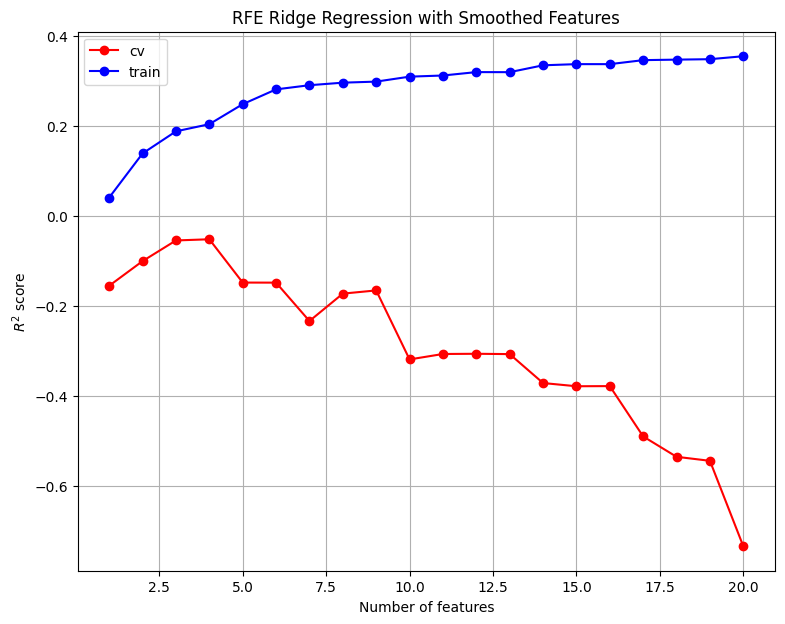

In [71]:
scaler = StandardScaler()

reg_pipe = Pipeline([
    ("scaler", scaler),
    ("model", Ridge(alpha=0.1, random_state=rand))])         # instantiate pipeline class, setting the scaler and model (ridge regression)
cv_score = []
train_score = []

for i in range(1, len(X_train_sm.columns)):
    rfe = RFE(Ridge(alpha=0.1, random_state=rand), n_features_to_select=i)
    rfe.fit(scaler.fit_transform(X_train_sm), scaler.fit_transform(y_train_sm))
    cols = X_train_sm.columns[rfe.support_]
    X_rfe = X_train_sm[cols]

    #  time-series aware cross validation  
    cv_reg = cross_validate(
        reg_pipe, X_rfe, y_train_sm, cv=tss, n_jobs=-1,
        scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
        return_train_score=True)

    cv_score.append(cv_reg['test_r2'].mean())
    train_score.append(cv_reg['train_r2'].mean())
    # print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}               {i}")
    # print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}\n")

plt.figure(figsize=(9,7))
plt.plot(range(1, len(X_train_sm.columns)), cv_score, 'o-', color='r', label='cv') 
plt.plot(range(1, len(X_train_sm.columns)), train_score, 'o-', color='b', label='train')
plt.xlabel("Number of features")
plt.ylabel("$R^2$ score")
plt.title("RFE Ridge Regression with Smoothed Features")
plt.legend()
plt.grid()
plt.show()


Peaks at 4 features, anymore adds model complexity/variance and overfits. 

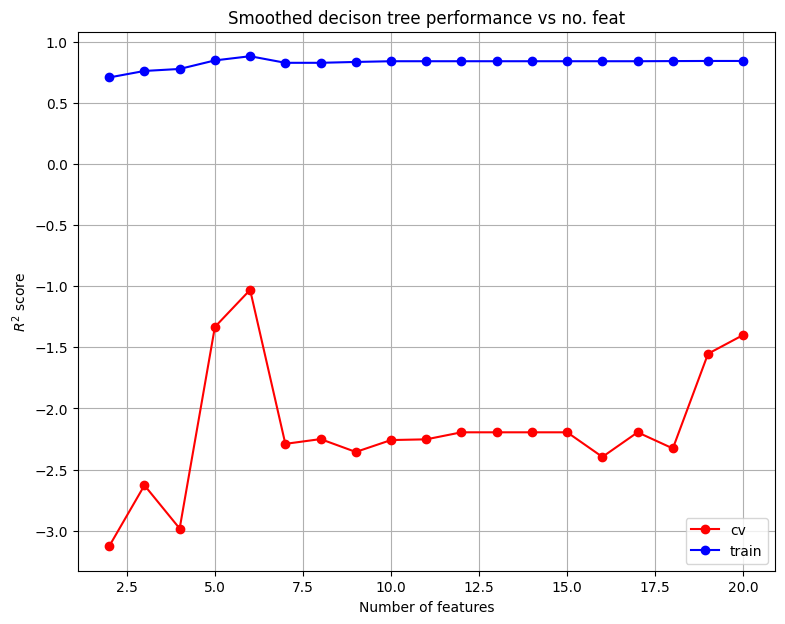

In [72]:
D_pipe = Pipeline([
    ("scaler", scaler),
    ("model", DecisionTreeRegressor(max_depth=5, random_state=rand))])         # instantiate pipeline class, setting the scaler and model (ridge regression)
cv_score = []
train_score = []

for i in range(2, len(X_train_sm.columns)):
    rfe = RFE(DecisionTreeRegressor(max_depth=5, random_state=rand), n_features_to_select=i)
    rfe.fit(scaler.fit_transform(X_train_sm), scaler.fit_transform(y_train_sm))
    cols = X_train_sm.columns[rfe.support_]
    X_rfe = X_train_sm[cols]

    #  time-series aware cross validation  
    cv_reg = cross_validate(
        D_pipe, X_rfe, y_train_sm, cv=tss, n_jobs=-1,
        scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
        return_train_score=True)

    cv_score.append(cv_reg['test_r2'].mean())
    train_score.append(cv_reg['train_r2'].mean())
    # print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}               {i}")
    # print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}\n")

plt.figure(figsize=(9,7))
plt.plot(range(2, len(X_train_sm.columns)), cv_score, 'o-', color='r', label='cv') 
plt.plot(range(2, len(X_train_sm.columns)), train_score, 'o-', color='b', label='train')
plt.title("Smoothed decison tree performance vs no. feat")
plt.xlabel("Number of features")
plt.ylabel("$R^2$ score")
plt.legend()
plt.grid()
plt.show()

Peaks at 6 features, with a negative $R^2$